In [1]:
from sii_fit import SII
from fit_routine import WLAX, Lines, lines, sii_doublet, c, z
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hdul1 = fits.open("../cube_rebin.fits")
head = hdul1[0].header
cubehdu = hdul1[0]
cubehead = cubehdu.header
cube = cubehdu.data


hdu = fits.open("../varc_rebin.fits")
varc = hdu[0].data

hdul2 = fits.open("../basespec_smoothed.fits")
basespec = hdul2[0].data

sii = SII('SII', lines['SII'][0], lines['SII'][1], lines['SII'][2], cube, varc, basespec)

In [8]:
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = sii.obs[0]
mask = (sii.lranges[0] < sii.wlax) & (sii.wlax < sii.lranges[1])
l_wlax = sii.wlax[mask]
l_lranges = sii.lranges

stime = time.time()
for i in tqdm(range(sii.cube_x), smoothing=1):
    for j in range(sii.cube_y):

        fit_spec, err_spec = sii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej +=1
            sii.rejcube[0,i,j] = 1
            continue

        try:

            popt, pcov = curve_fit(sii_doublet, l_wlax, fit_spec[mask], p0=[1760, 1500, obs_0, 2.3, 0], 
                                    bounds=([0,0,l_lranges[0],0, -50], [3e4, 3e4, l_lranges[1], 50, 50]), 
                                    absolute_sigma=True, sigma=err_spec[mask])

            uncertainty = np.sqrt(np.diagonal(np.abs(pcov))[0:6])
            snr1 = popt[0] / uncertainty[0]
            snr2 = popt[1] / uncertainty[1]

            if  snr1 > 3. and snr2 > 3.:
                sii.fitcube[:5,i,j] = popt[:]
                sii.fitcube[5,i,j] = snr1
                sii.fitcube[6,i,j] = snr2
                sii.fiterrcube[:,i,j] = uncertainty
            else:
                sii.fitcube[:5,i,j] = np.nan
                sii.fitcube[5,i,j] = snr1
                sii.fitcube[6,i,j] = snr2

                sii.rejcube[1,i,j] = 1
                snrrej += 1

        except (RuntimeError, ValueError):
            sii.set_to_nan(i, j)
            sii.rejcube[2,i,j] = 1
            runerr +=1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)

newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(sii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(sii.fitcube[i]) for i in range(1,sii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(sii.fiterrcube[i]) for i in range(sii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Sii_fit/sii_fit_cont.fits', overwrite = True)

rejhdus = fits.PrimaryHDU(sii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(sii.rejcube[i]) for i in range(1,sii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Sii_fit/sii_rej_cont.fits', overwrite = True)

detectedimg = np.nan_to_num(sii.fitcube[0])
snrrejimg = np.nan_to_num(sii.rejcube[1])
evalimg = detectedimg + snrrejimg

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Sii_fit/sii_eval_cont.fits', overwrite = True)

flux0hdus = [prihdu]
flux1hdus = [fits.ImageHDU(sii.fitcube[1])]
velhdus = [fits.ImageHDU(c*(sii.fitcube[2]/sii.rest[0]-1-z))]
vdisphdus = [fits.ImageHDU(c*(sii.fitcube[3]/sii.rest[0]))]
resulthdus =  fits.HDUList(flux0hdus+flux1hdus+velhdus+vdisphdus)
resulthdus.writeto('../Sii_fit/sii_result_cont.fits', overwrite=True)

  5%|▍         | 3/65 [00:22<08:25,  8.15s/it]/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:173: RuntimeWarning: invalid value encountered in sqrt
  return fit_spec, deepcopy(np.sqrt(self.varspec))
/Users/gordonwongyl/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
  6%|▌         | 4/65 [00:29<06:51,  6.74s/it]/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Scripts/fit_routine.py:169: RuntimeWarning: invalid value encountered in sqrt
  if sum(fit_spec)/np.sqrt(sum(self.varspec)) < self.quickrej_threshold:
 18%|█▊        | 12/65 [01:09<03:45,  4.26s/it]/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_80066/2766827802.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  snr1 = popt[0] / uncertainty[0]
/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_800

1861
2271
280
390.83240509033203


In [3]:
sii.load_fitcubes('../Sii_fit/sii_fit_cont.fits')
sii.fiterrcube.shape

(5, 65, 92)

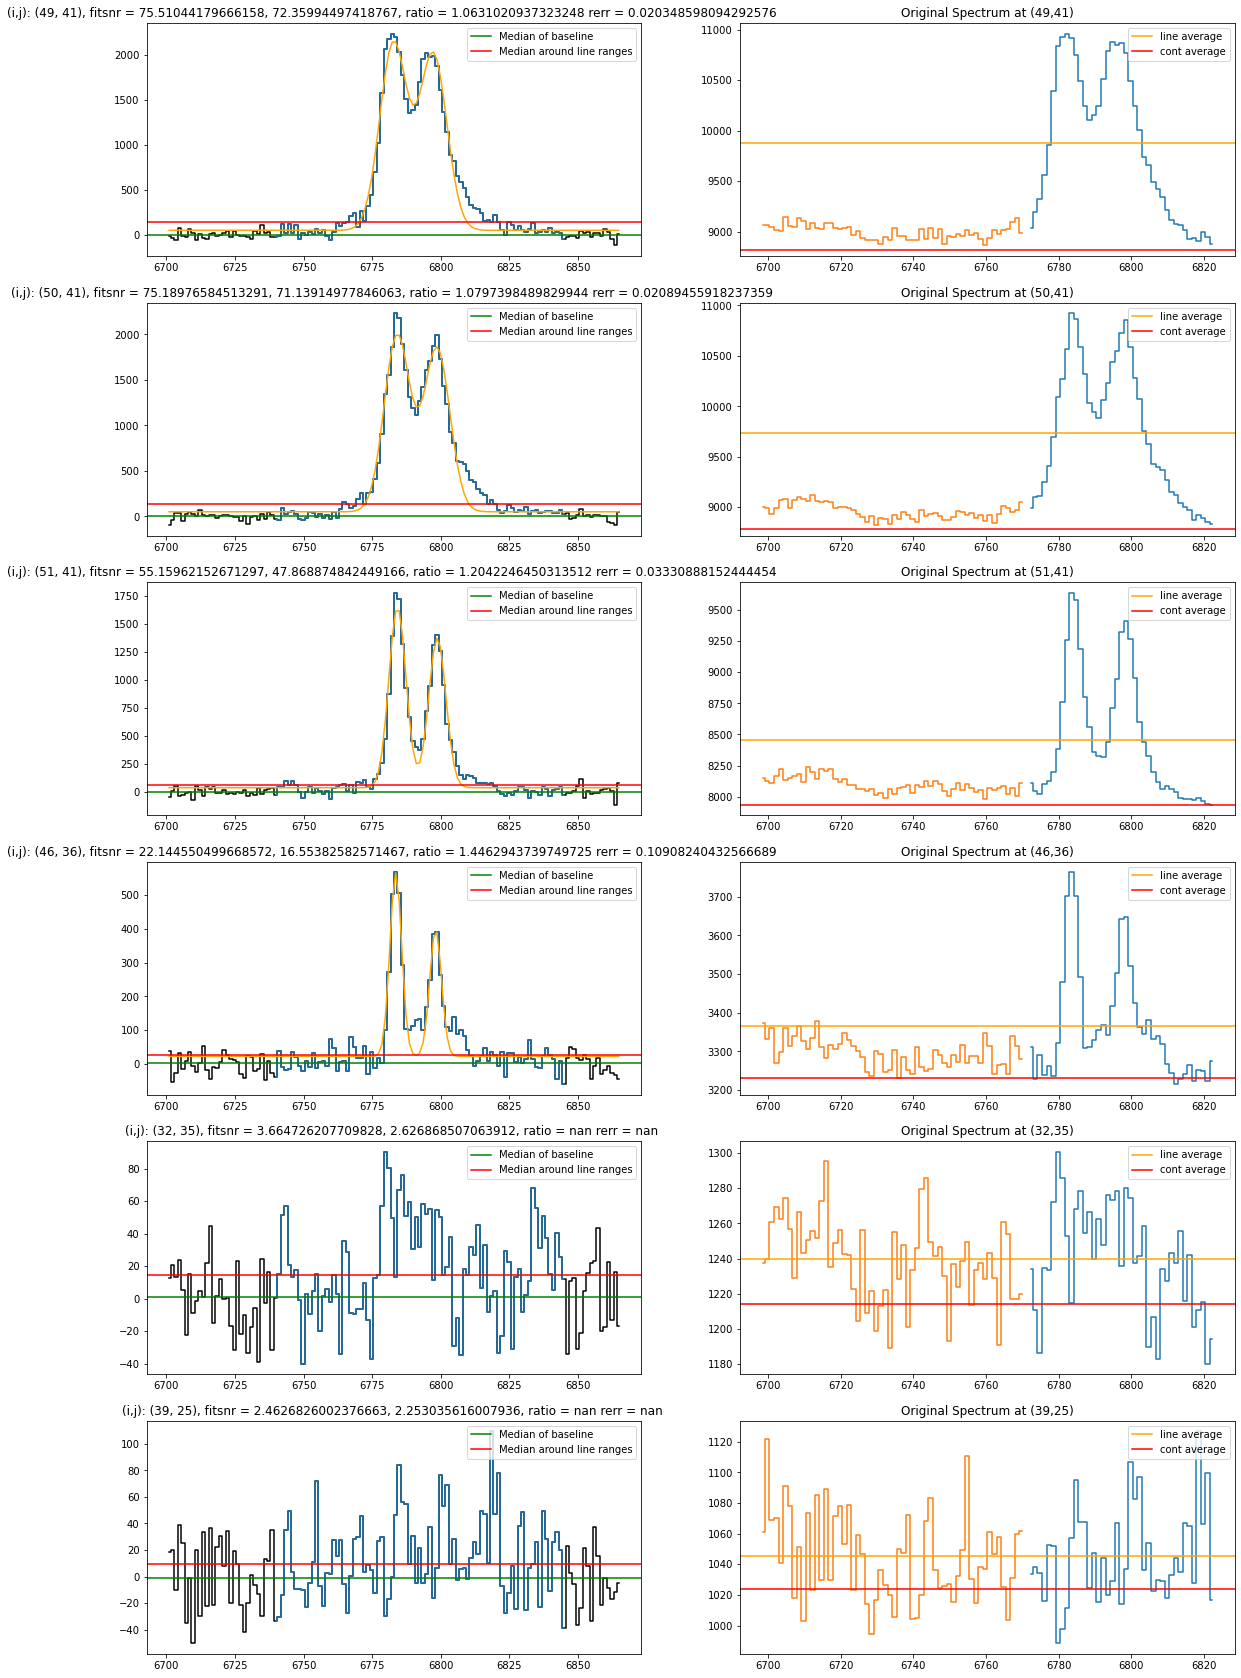

In [7]:
HIGH_CONT = [(49,41), (50,41) ,(51, 41), (46,36)]
REJ = [(32,35), (39,25)]
sii.plot_eval(HIGH_CONT+REJ)
